# Computing differential rates $\frac{dR}{dE}$ and modulation amplitudes for ANAIS.

See <a href="https://arxiv.org/pdf/1802.03174">Surrogate Models for Direct Dark Matter Detection</a> for RAPIDD specific doc.

## IMPORTS

In [10]:
import sys            # módulo para interactuar con el intérprete
import os             # módulo para operaciones del sistema de archivos
import numpy as np    # librería numérica
import matplotlib.pyplot as plt  # para crear gráficos
import math as math

In this implementation RAPIDD needs to be implemented in this way:

In [11]:
# Ruta absoluta del directorio donde se ejecuta el script
route_module = os.path.abspath('RAPIDD_for_DM')

# Añadir esa ruta al PATH de Python
sys.path.append(route_module)

# Mostrar las rutas que Python revisa al importar módulos
print(sys.path)

['/home/borja/Documents/TFG/RAPIDD_ANAIS/rapidd', '/home/borja/anaconda3/lib/python39.zip', '/home/borja/anaconda3/lib/python3.9', '/home/borja/anaconda3/lib/python3.9/lib-dynload', '', '/home/borja/anaconda3/lib/python3.9/site-packages', '/home/borja/Documents/TFG/RAPIDD_ANAIS/rapidd/RAPIDD_for_DM', '/home/borja/Documents/TFG/RAPIDD_ANAIS/rapidd/RAPIDD_for_DM']


In [12]:
from core import base_dir, reset_coefficients, isofromneuc, set_any_Ncoeff, read_halo, difrate_dER

## Building RAPIDD functions

The following functions take RAPIDD inner functions to compute both the differential rate and the modulation amplitude.

rho : DM local density<br>
target: target material ('Na' for Sodium and 'I' for iodine)<br>
basis: basis to figve the NREFT coefficients, 'All' stands for the proton/neutron basis<br>
day, month: day and month to compute the expected differential rate<br>
halo_dir: directory with the halo_functions files

In [13]:
@np.vectorize
def diffrate_mod(mass, er, rho=.3, target='Na', basis='All',
                 day=22, month=3, halo_dir="halo_tables/"):
    """
    Calcula la tasa diferencial (diffrate) para una lista de masas
    y energías de referencia (er) utilizando un *halo* pre‑calculado
    que se lee desde un fichero *.dat*.

    Parámetros
    ----------
    mass : float | array_like
        Masa (en unidades de tu modelo, por ejemplo Msun).
    er   : float | array_like
        Energía de referencia (puede ser un valor escalar o un array).
    rho  : float, optional
        Densidad del halo. Valor por defecto 0.33.
    target : str, optional
        Elemento químico objetivo. Ej.: 'Na'.
    basis : str, optional
        ¿Qué parte del halo usar?  'All' por defecto.
    day   : int, optional
        Día del halo que se va a leer (4 por defecto).
    month : int, optional
        Mes del halo que se va a leer (3 por defecto).
    halo_dir : str, optional
        Directorio donde se guardan los ficheros *.dat*.

    Returns
    -------
    array_like
        Valores de la función `difrate_dER` evaluados para cada
        combinación de `mass` y `er`.

    """
    # Comprueba que el fichero exista
    halo_file = f"{halo_dir}halo_{month}_{day}.dat"
    if not os.path.exists(halo_file):
        raise FileNotFoundError(f"File not found: {halo_file}")

    # Lee el halo (el propio `read_halo` suele cambiar
    #     algún estado global, de modo que la llamada sea necesaria)
    read_halo(halo_file)

    # Evalúa la función `difrate_dER` para cada (mass, er)
    #     y lo vuelve vectorizado una segunda vez.
    #     (La primera vectorización proviene del decorador @np.vectorize)
    return np.vectorize(difrate_dER)(rho, mass, er,
                                     target=target, basis=basis)

In [14]:
@np.vectorize
def modulation(mass, er, rho=.3, target='Na', basis='All', halo_dir = "halo_tables/"):

    if not(os.path.exists(halo_dir+'halo_6_1.dat')):
        raise FileNotFoundError(f"File not found: {halo_dir+'halo_6_1.dat'}")
    if not(os.path.exists(halo_dir+'halo_12_1.dat')):
        raise FileNotFoundError(f"File not found: {halo_dir+'halo_12_1.dat'}")

    read_halo(halo_dir+'halo_6_1.dat')
    a = np.vectorize(difrate_dER)(rho, mass, er, target=target, basis=basis)
    read_halo(halo_dir+'halo_12_1.dat')
    b = np.vectorize(difrate_dER)(rho, mass, er, target=target, basis=basis)
    
    return .5*(a-b)

In [15]:
@np.vectorize
def rate_av(mass, er, rho=.3, target='Ge', basis='All', output_dir = "halo_tables/"):

    if not(os.path.exists(output_dir+'halo_6_1.dat')) or not(os.path.exists(output_dir+'halo_12_1.dat')):
        print("Halo File not found!!!")
        return

    read_halo(output_dir+'halo_6_1.dat')
    a = np.vectorize(difrate_dER)(rho, mass, er, target=target, basis=basis)
    read_halo(output_dir+'halo_12_1.dat')
    b = np.vectorize(difrate_dER)(rho, mass, er, target=target, basis=basis)
    
    return .5*(a+b)

# Some Examples

Let's define a sample mass $m_\chi=50$ GeV and a range of energies in keV to compute the rates.

### Operator $\mathcal{O}_1$

#### Differential Rate

This function puts all the NREFT coefficients to zero:

In [16]:
reset_coefficients()
set_any_Ncoeff(1, 1, "p")
set_any_Ncoeff(1, 1, "n")

Now we fix to "one" the coefficient of $\mathcal{O}_1$ for both protons and neutrons.

In RAPIDD convention, coefficients are chosen to be dimensionless normalized by the Higgs vacuum expectation value (see [1802.03174] for more info).

In [17]:
energies = np.linspace(0.01, 100, 500) # keV
mW=50 


<Figure size 1008x576 with 0 Axes>

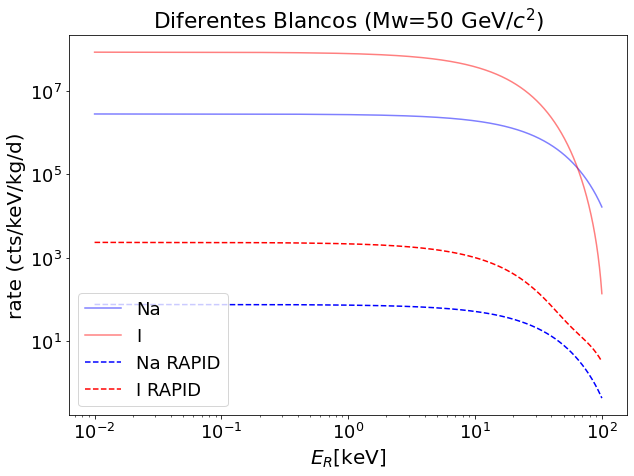

<Figure size 1008x576 with 0 Axes>

In [18]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm

from funciones_ritmo_teorico import*
#from funciones_ritmo_exp import*


plt.rcParams['font.size'] = 18

#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en cts/kg/d)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2

def rate(E,t,A,mW,sigmaSI):
    Mdet=1000*NA*mn                                 # masa de 1 kg de detector [GeV/c^2]
    mu_n=mW*mn/(mW+mn)                              # masa reducida del sistema nucleon-WIMP [Gev/c^2]
    retval=Mdet*rho/2./mW/mu_n/mu_n*A*A*sigmaSI     # Producto de los primeros terminos [cts*c^2/Gev/cm]
    retval*=c*c                                     # Conversion a 100*[cts*m/s^2/Gev]
    retval*=FF(E,A)                                 # Multiplicamos por factor de forma atomico (Adimensional) 100*[cts*m/s^2/Gev]
    retval*=eta(E,t,A,mW)                           # Multiplicamos por integral 0.1*[cts/GeV/s]
    retval*=8.64e-3                                 # Convertimos a [cts/KeV/d]

    return retval

# Dia promedio

timeMax=72.9 
timeMin=255.5 
timeAvg=0.

#Valores cualquiera de masa del WIMP y de la seccion eficaz

       #   masa wimp (geV/c^2)
si=1e-33        #   seccion eficaz SI(cm^-2)


ene=energies
m = mW # GeV





drde_Na_1 = diffrate_mod(m, energies, target='Na')
drde_I_1 = diffrate_mod(m, energies, target='I')
#Vector con los diferentes valores de la energia, entre 0 y 100 keV y con una resolucion de 0.1 keV)



#Calculamos los valores del ritmo diferencial

rateNa=np.array([rate(e,timeAvg,23,mW,si) for e in ene])
rateI=np.array([rate(e,timeAvg,127,mW,si) for e in ene])
#rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

#Dibujamos

plt.figure(figsize=(10, 7))
ax = plt.subplot()
ax.plot(ene,rateNa, label = "Na", c='b', alpha=0.5)
ax.plot(ene,rateI, label = "I",c='r', alpha=0.5)

plt.plot(energies, drde_Na_1,linestyle='--', c='b', label='Na RAPID')
plt.plot(energies, drde_I_1,linestyle='--', c='r', label='I RAPID')

#ax.plot(ene,rate_NaI, label = "NaI")
ax.set_title(r'Diferentes Blancos (Mw=' + str(np.round(mW)) + ' GeV/$c^2$)')
ax.set_ylabel(r'rate (cts/keV/kg/d)',fontsize=20)
ax.set_xlabel(r'$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")





plt.figure(figsize=(14, 8))




<Figure size 1008x576 with 0 Axes>

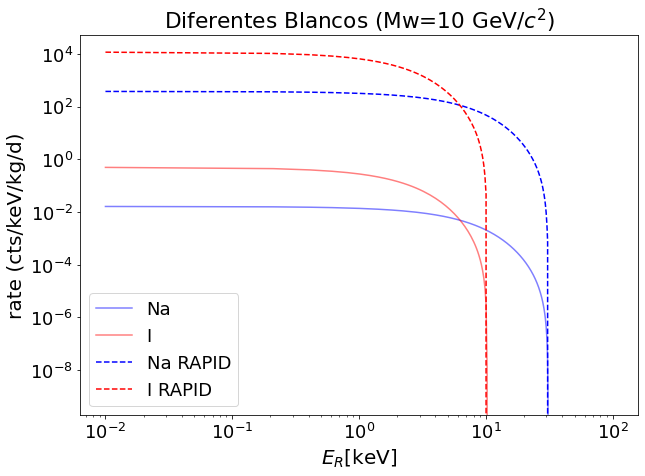

<Figure size 1008x576 with 0 Axes>

In [19]:
energies = np.linspace(0.01, 100, 500) # keV
mW=10 
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm

from funciones_ritmo_teorico import*
#from funciones_ritmo_exp import*


plt.rcParams['font.size'] = 18

#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en cts/kg/d)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2

def rate(E,t,A,mW,sigmaSI):
    Mdet=1000*NA*mn                                 # masa de 1 kg de detector [GeV/c^2]
    mu_n=mW*mn/(mW+mn)                              # masa reducida del sistema nucleon-WIMP [Gev/c^2]
    retval=Mdet*rho/2./mW/mu_n/mu_n*A*A*sigmaSI     # Producto de los primeros terminos [cts*c^2/Gev/cm]
    retval*=c*c                                     # Conversion a 100*[cts*m/s^2/Gev]
    retval*=FF(E,A)                                 # Multiplicamos por factor de forma atomico (Adimensional) 100*[cts*m/s^2/Gev]
    retval*=eta(E,t,A,mW)                           # Multiplicamos por integral 0.1*[cts/GeV/s]
    retval*=8.64e-3                                 # Convertimos a [cts/KeV/d]

    return retval

# Dia promedio

timeMax=72.9 
timeMin=255.5 
timeAvg=0.

#Valores cualquiera de masa del WIMP y de la seccion eficaz

       #   masa wimp (geV/c^2)
si=1e-42        #   seccion eficaz SI(cm^-2)


ene=energies
m = mW # GeV





drde_Na_1 = diffrate_mod(m, energies, target='Na')
drde_I_1 = diffrate_mod(m, energies, target='I')
#Vector con los diferentes valores de la energia, entre 0 y 100 keV y con una resolucion de 0.1 keV)



#Calculamos los valores del ritmo diferencial

rateNa=np.array([rate(e,timeAvg,23,mW,si) for e in ene])
rateI=np.array([rate(e,timeAvg,127,mW,si) for e in ene])
#rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

#Dibujamos

plt.figure(figsize=(10, 7))
ax = plt.subplot()
ax.plot(ene,rateNa, label = "Na", c='b', alpha=0.5)
ax.plot(ene,rateI, label = "I",c='r', alpha=0.5)

plt.plot(energies, drde_Na_1,linestyle='--', c='b', label='Na RAPID')
plt.plot(energies, drde_I_1,linestyle='--', c='r', label='I RAPID')

#ax.plot(ene,rate_NaI, label = "NaI")
ax.set_title(r'Diferentes Blancos (Mw=' + str(np.round(mW)) + ' GeV/$c^2$)')
ax.set_ylabel(r'rate (cts/keV/kg/d)',fontsize=20)
ax.set_xlabel(r'$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")





plt.figure(figsize=(14, 8))




In [20]:
mW=50 
emes = [1,5,10,12,15,20,30,40,50,100,200,500,1000] # keV
emes = np.array(emes) # keV
energies = np.linspace(0.01, 1000, 5000) # keV

/tmp/ipykernel_17796/3384529068.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 7))


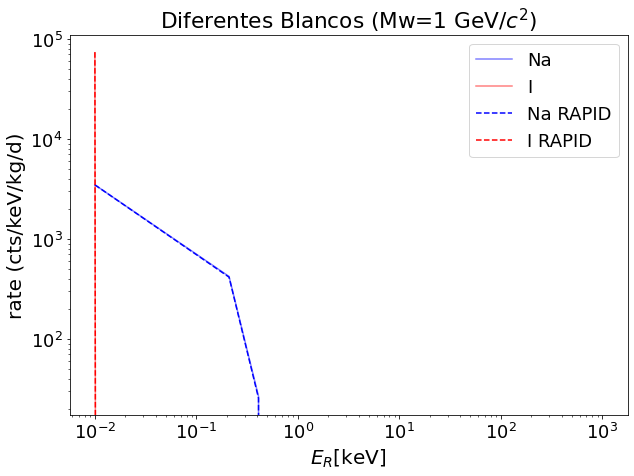

<Figure size 1008x576 with 0 Axes>

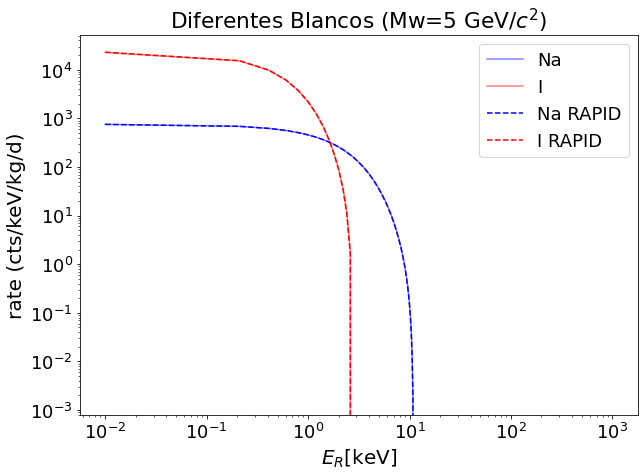

<Figure size 1008x576 with 0 Axes>

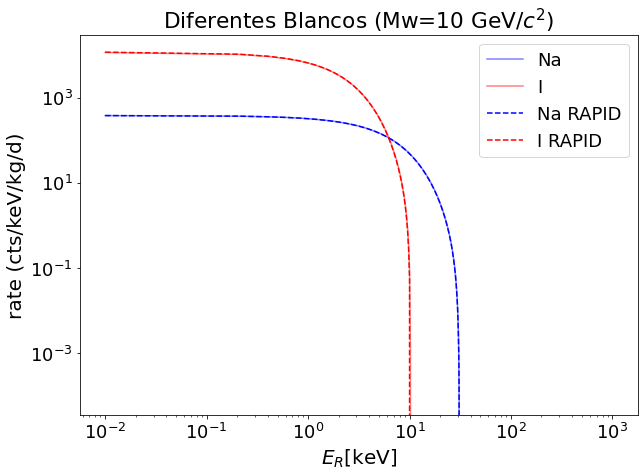

<Figure size 1008x576 with 0 Axes>

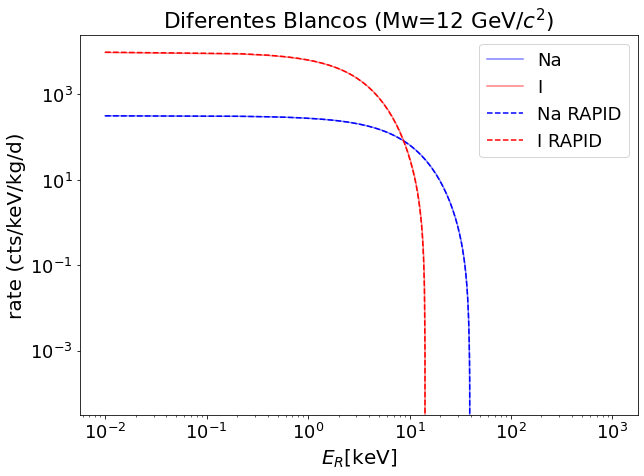

<Figure size 1008x576 with 0 Axes>

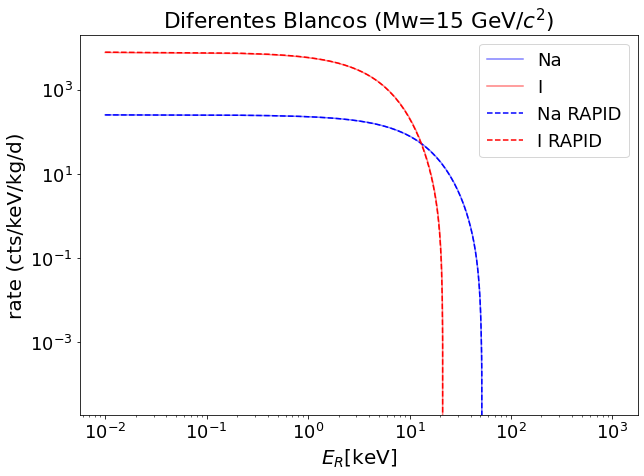

<Figure size 1008x576 with 0 Axes>

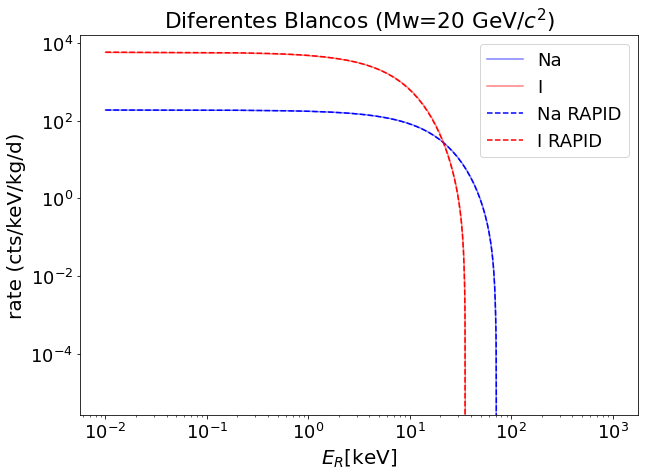

<Figure size 1008x576 with 0 Axes>

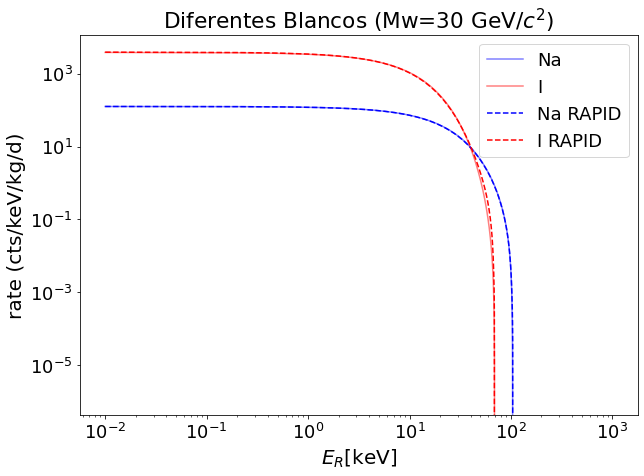

<Figure size 1008x576 with 0 Axes>

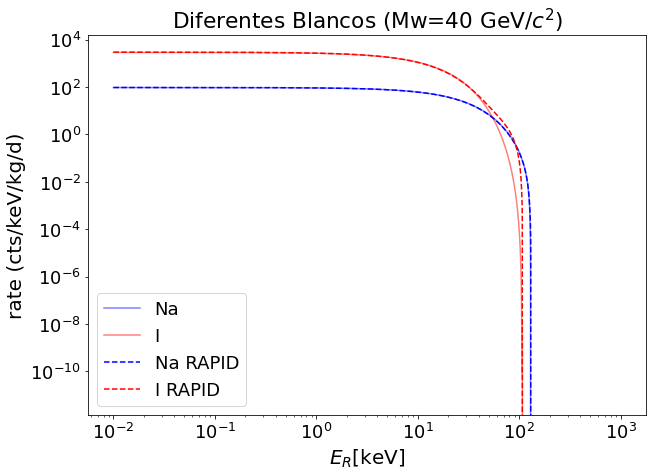

<Figure size 1008x576 with 0 Axes>

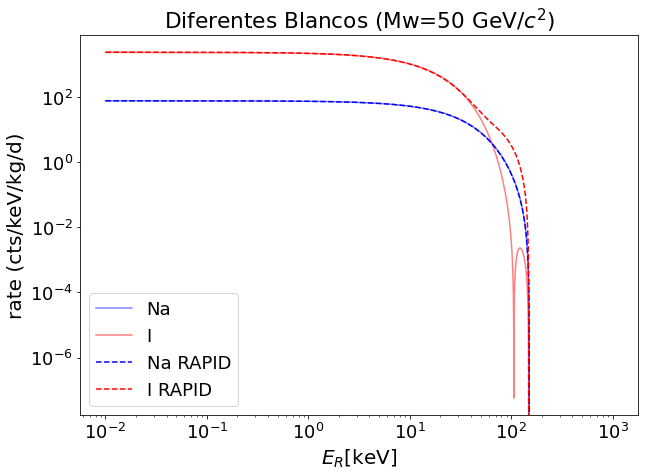

<Figure size 1008x576 with 0 Axes>

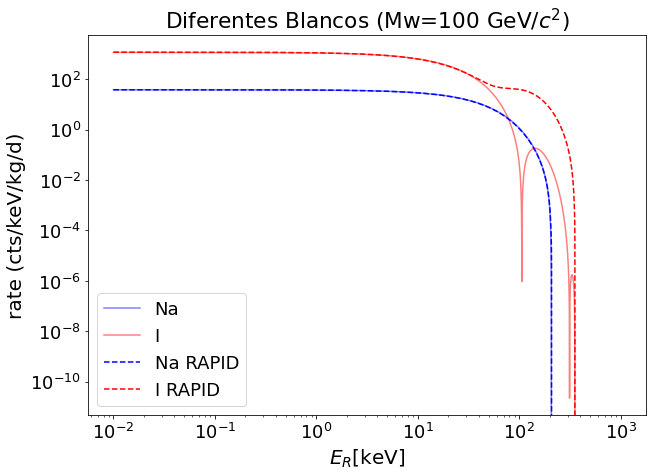

<Figure size 1008x576 with 0 Axes>

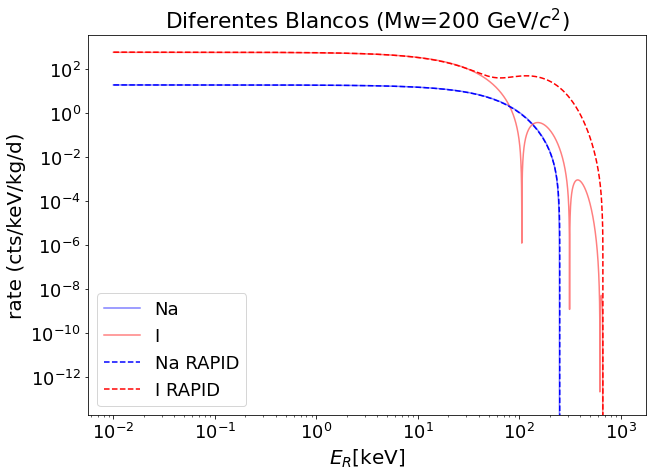

<Figure size 1008x576 with 0 Axes>

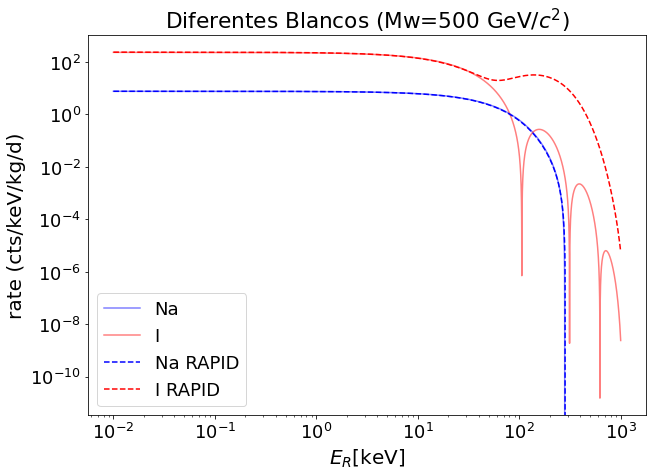

<Figure size 1008x576 with 0 Axes>

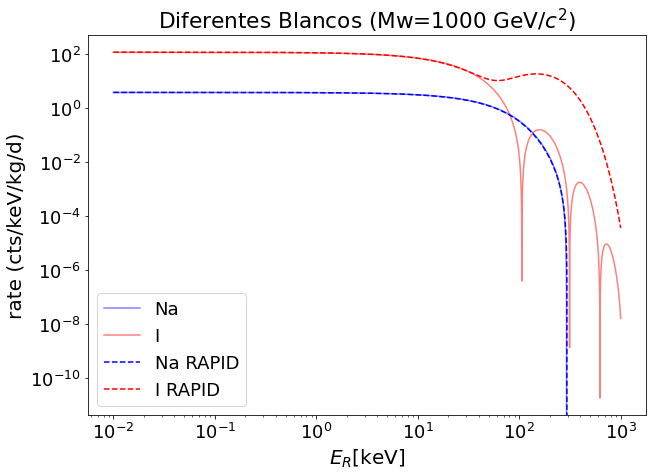

<Figure size 1008x576 with 0 Axes>

In [21]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm

from funciones_ritmo_teorico import*
#from funciones_ritmo_exp import*


plt.rcParams['font.size'] = 18

#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en cts/kg/d)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2

def rate(E,t,A,mW,sigmaSI):
    Mdet=1000*NA*mn                                 # masa de 1 kg de detector [GeV/c^2]
    mu_n=mW*mn/(mW+mn)                              # masa reducida del sistema nucleon-WIMP [Gev/c^2]
    retval=Mdet*rho/2./mW/mu_n/mu_n*A*A*sigmaSI     # Producto de los primeros terminos [cts*c^2/Gev/cm]
    retval*=c*c                                     # Conversion a 100*[cts*m/s^2/Gev]
    retval*=FF(E,A)                                 # Multiplicamos por factor de forma atomico (Adimensional) 100*[cts*m/s^2/Gev]
    retval*=eta(E,t,A,mW)                           # Multiplicamos por integral 0.1*[cts/GeV/s]
    retval*=8.64e-3                                 # Convertimos a [cts/KeV/d]

    return retval

# Dia promedio

timeMax=72.9 
timeMin=255.5 
timeAvg=0.

#Valores cualquiera de masa del WIMP y de la seccion eficaz

       #   masa wimp (geV/c^2)



ene=energies




for i in range(len(emes)):

    mW=emes[i]
    m = mW # GeV
    drde_Na_1 = diffrate_mod(m, energies, target='Na')
    drde_I_1 = diffrate_mod(m, energies, target='I')
    #Vector con los diferentes valores de la energia, entre 0 y 100 keV y con una resolucion de 0.1 keV)

    si=drde_Na_1[0]/rate(ene[0],timeAvg,23,mW,1)

    #Calculamos los valores del ritmo diferencial

    rateNa=np.array([rate(e,timeAvg,23,mW,si) for e in ene])
    rateI=np.array([rate(e,timeAvg,127,mW,si) for e in ene])
    #rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

    #Dibujamos

    plt.figure(figsize=(10, 7))
    ax = plt.subplot()
    ax.plot(ene,rateNa, label = "Na", c='b', alpha=0.5)
    ax.plot(ene,rateI, label = "I",c='r', alpha=0.5)

    plt.plot(energies, drde_Na_1,linestyle='--', c='b', label='Na RAPID')
    plt.plot(energies, drde_I_1,linestyle='--', c='r', label='I RAPID')

    #ax.plot(ene,rate_NaI, label = "NaI")
    ax.set_title(r'Diferentes Blancos (Mw=' + str(np.round(mW)) + ' GeV/$c^2$)')
    ax.set_ylabel(r'rate (cts/keV/kg/d)',fontsize=20)
    ax.set_xlabel(r'$E_{R}$'+ '[keV]',fontsize=20)
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")





    plt.figure(figsize=(14, 8))




/tmp/ipykernel_17796/3662272041.py:73: RuntimeWarning: invalid value encountered in double_scalars
  iii[i]=(rateI[i]- drde_I_1[i])/rateI[i]
/tmp/ipykernel_17796/3662272041.py:72: RuntimeWarning: invalid value encountered in double_scalars
  naa[i]=(rateNa[i]- drde_Na_1[i])/rateNa[i]
/tmp/ipykernel_17796/3662272041.py:73: RuntimeWarning: invalid value encountered in double_scalars
  iii[i]=(rateI[i]- drde_I_1[i])/rateI[i]
/tmp/ipykernel_17796/3662272041.py:72: RuntimeWarning: invalid value encountered in double_scalars
  naa[i]=(rateNa[i]- drde_Na_1[i])/rateNa[i]
/tmp/ipykernel_17796/3662272041.py:73: RuntimeWarning: invalid value encountered in double_scalars
  iii[i]=(rateI[i]- drde_I_1[i])/rateI[i]
/tmp/ipykernel_17796/3662272041.py:72: RuntimeWarning: invalid value encountered in double_scalars
  naa[i]=(rateNa[i]- drde_Na_1[i])/rateNa[i]
/tmp/ipykernel_17796/3662272041.py:73: RuntimeWarning: invalid value encountered in double_scalars
  iii[i]=(rateI[i]- drde_I_1[i])/rateI[i]
/tmp

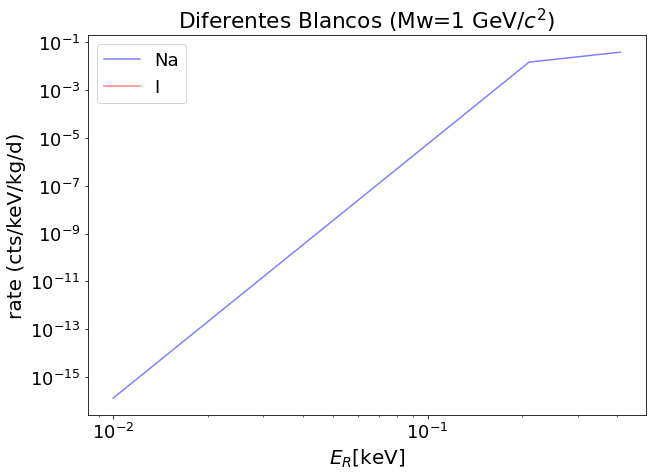

<Figure size 1008x576 with 0 Axes>

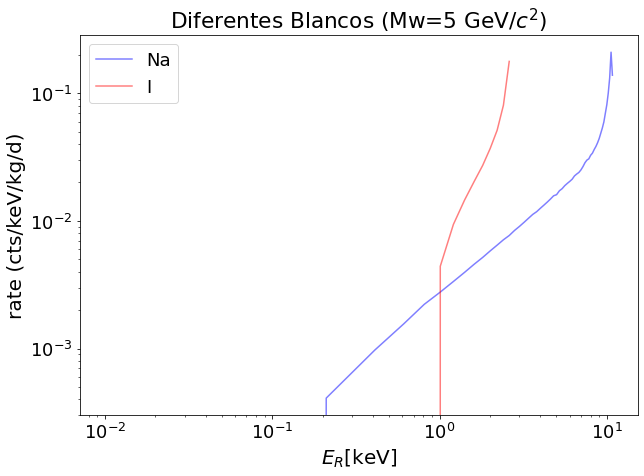

<Figure size 1008x576 with 0 Axes>

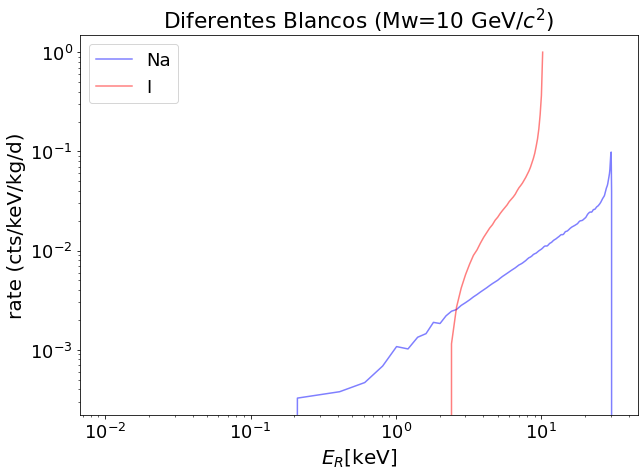

<Figure size 1008x576 with 0 Axes>

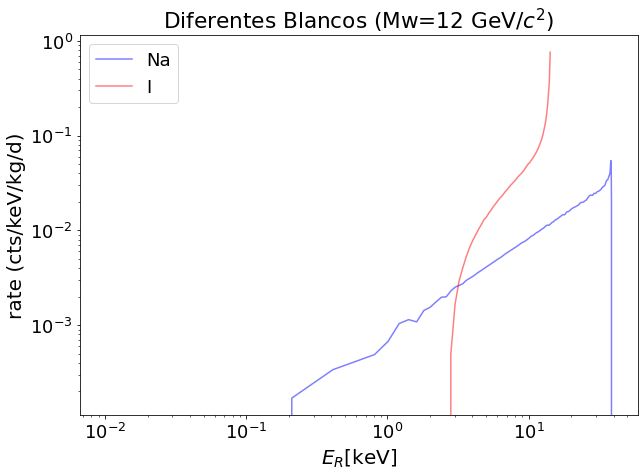

<Figure size 1008x576 with 0 Axes>

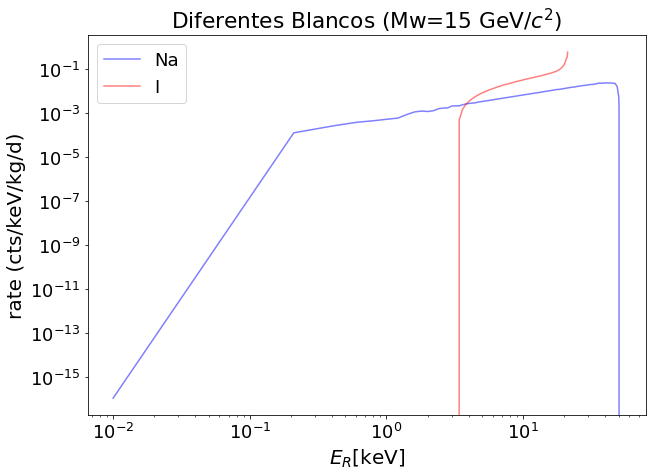

<Figure size 1008x576 with 0 Axes>

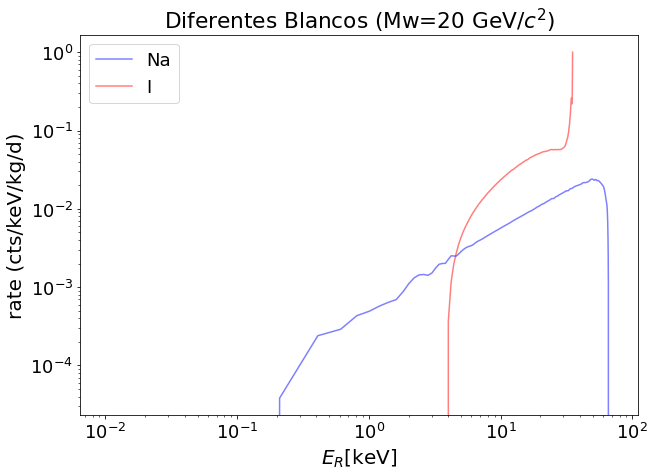

<Figure size 1008x576 with 0 Axes>

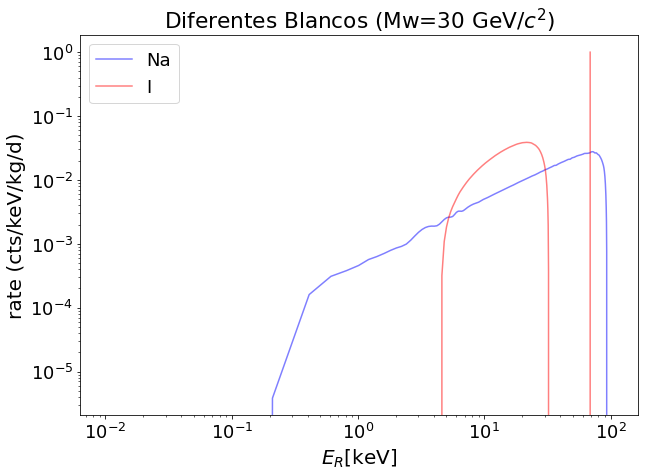

<Figure size 1008x576 with 0 Axes>

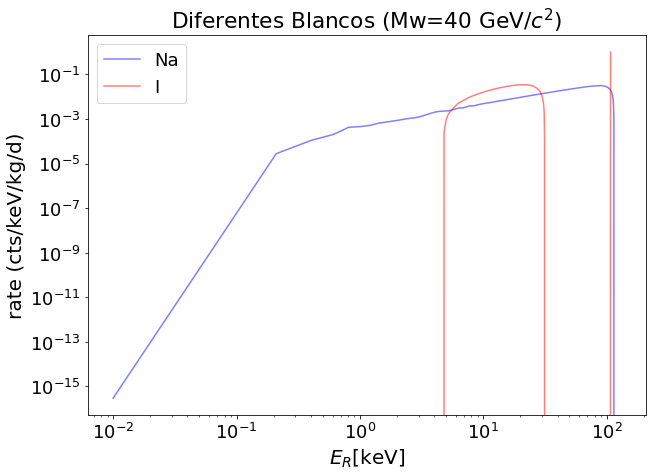

<Figure size 1008x576 with 0 Axes>

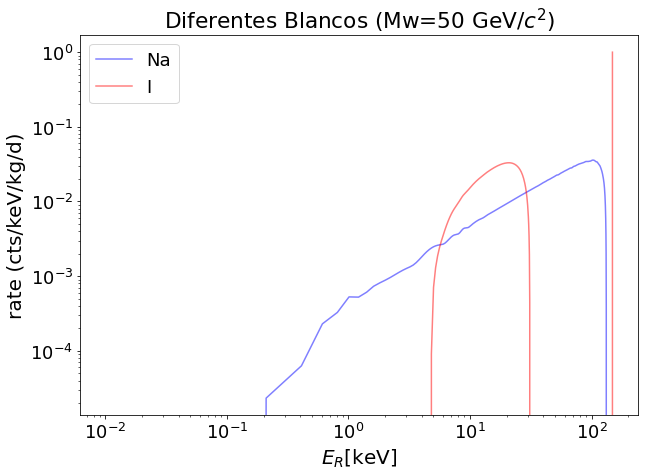

<Figure size 1008x576 with 0 Axes>

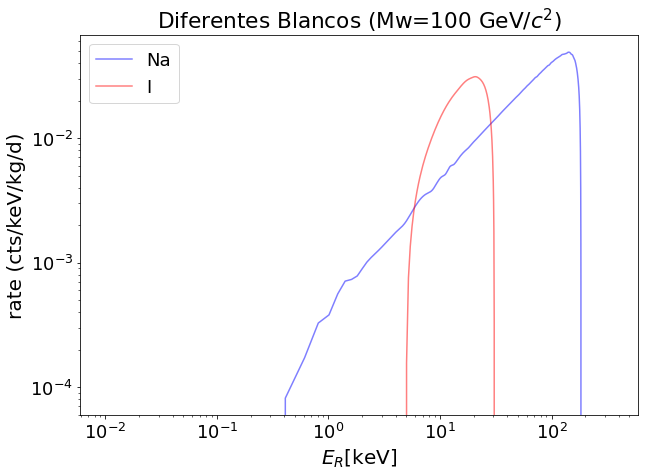

<Figure size 1008x576 with 0 Axes>

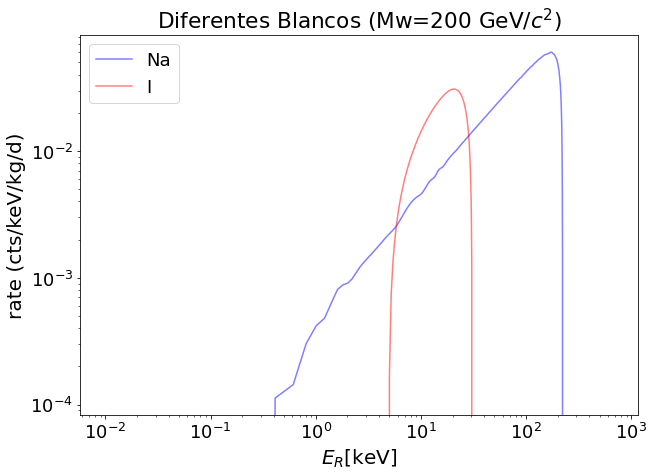

<Figure size 1008x576 with 0 Axes>

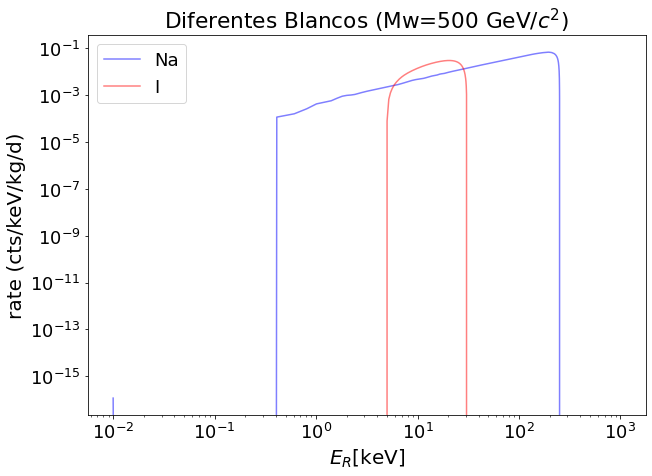

<Figure size 1008x576 with 0 Axes>

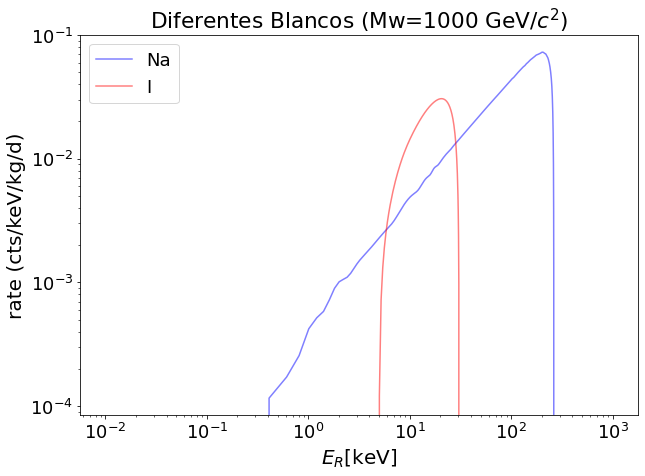

<Figure size 1008x576 with 0 Axes>

In [22]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm

from funciones_ritmo_teorico import*
#from funciones_ritmo_exp import*


plt.rcParams['font.size'] = 18

#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en cts/kg/d)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2

def rate(E,t,A,mW,sigmaSI):
    Mdet=1000*NA*mn                                 # masa de 1 kg de detector [GeV/c^2]
    mu_n=mW*mn/(mW+mn)                              # masa reducida del sistema nucleon-WIMP [Gev/c^2]
    retval=Mdet*rho/2./mW/mu_n/mu_n*A*A*sigmaSI     # Producto de los primeros terminos [cts*c^2/Gev/cm]
    retval*=c*c                                     # Conversion a 100*[cts*m/s^2/Gev]
    retval*=FF(E,A)                                 # Multiplicamos por factor de forma atomico (Adimensional) 100*[cts*m/s^2/Gev]
    retval*=eta(E,t,A,mW)                           # Multiplicamos por integral 0.1*[cts/GeV/s]
    retval*=8.64e-3                                 # Convertimos a [cts/KeV/d]

    return retval

# Dia promedio

timeMax=72.9 
timeMin=255.5 
timeAvg=0.

#Valores cualquiera de masa del WIMP y de la seccion eficaz

       #   masa wimp (geV/c^2)



ene=energies




for i in range(len(emes)):

    mW=emes[i]
    m = mW # GeV
    drde_Na_1 = diffrate_mod(m, energies, target='Na')
    drde_I_1 = diffrate_mod(m, energies, target='I')
    #Vector con los diferentes valores de la energia, entre 0 y 100 keV y con una resolucion de 0.1 keV)

    si=drde_Na_1[0]/rate(ene[0],timeAvg,23,mW,1)

    #Calculamos los valores del ritmo diferencial

    rateNa=np.array([rate(e,timeAvg,23,mW,si) for e in ene])
    rateI=np.array([rate(e,timeAvg,127,mW,si) for e in ene])
    #rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

    #Dibujamos

    naa=rateNa
    iii=rateI

    for i in range (len(naa)):
        naa[i]=(rateNa[i]- drde_Na_1[i])/rateNa[i]
        iii[i]=(rateI[i]- drde_I_1[i])/rateI[i]

    plt.figure(figsize=(10, 7))
    ax = plt.subplot()
    ax.plot(ene,naa, label = "Na", c='b', alpha=0.5)
    ax.plot(ene,iii, label = "I",c='r', alpha=0.5)

    #ax.plot(ene,rate_NaI, label = "NaI")
    ax.set_title(r'Diferentes Blancos (Mw=' + str(np.round(mW)) + ' GeV/$c^2$)')
    ax.set_ylabel(r'rate (cts/keV/kg/d)',fontsize=20)
    ax.set_xlabel(r'$E_{R}$'+ '[keV]',fontsize=20)
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")





    plt.figure(figsize=(14, 8))




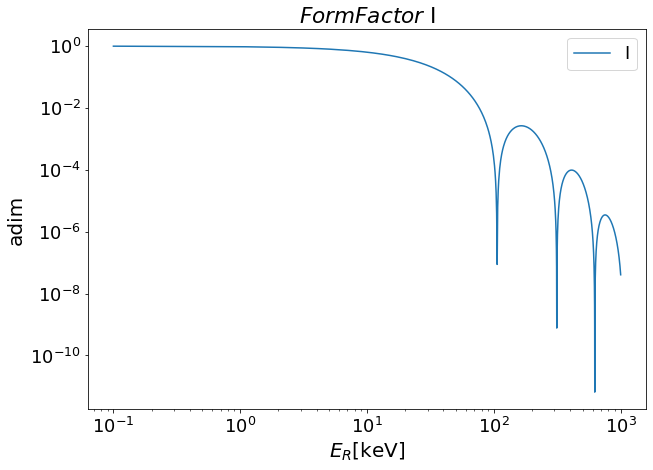

In [23]:
energies = np.linspace(0.1, 1000, 1000) # keV
#energies = np.linspace(0.1, 1e3, 10000) # keV
ene=energies


FACTORFORMA=np.array([FF(e,127) for e in ene])
#rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

#Dibujamos

plt.figure(figsize=(10, 7))
ax = plt.subplot()
#ax.plot(ene,rateNa, label = "Na")
ax.plot(ene,FACTORFORMA, label = "I")

#ax.plot(ene,rate_NaI, label = "NaI")
ax.set_title(r'$Form Factor$ I')
ax.set_ylabel(r'adim',fontsize=20)
ax.set_xlabel(r'$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")



[ 106.06259561  313.49847135  624.58488246 1039.35350894 1557.80996078]
[1.09868922e-14 1.33006596e-16 1.22543190e-18 3.54611576e-20
 1.06011580e-21]


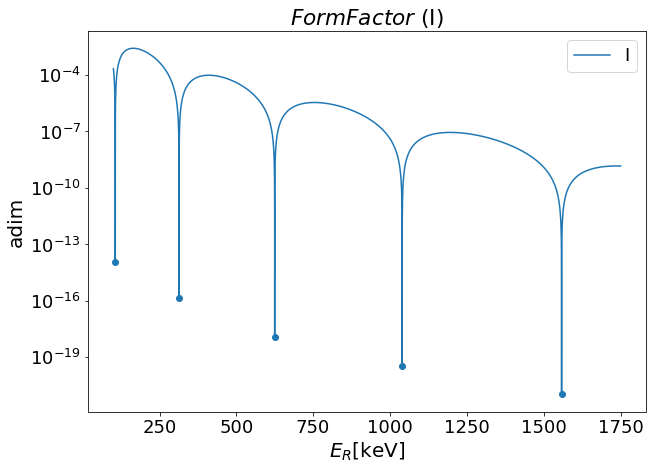

In [24]:
energies = np.linspace(100, 1750, 10000000) # keV
#energies = np.linspace(0.1, 1e3, 10000) # keV
ene=energies
FACTORFORMA=np.array([FF(e,127) for e in ene])
#rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])
minimos=[]
b=0
i=1
modo=0
valor=FACTORFORMA[0]
while b==0:
    if modo==0:
        valor2=FACTORFORMA[i]
        if valor2>valor:
            minimos.append(ene[i-1])
            modo=1
        valor=valor2
    if modo==1:
        valor2=FACTORFORMA[i]
        if valor2<valor:
            modo=0
        valor=valor2
    i=i+1
    if i>len(FACTORFORMA)-1:
        b=1
minimos=np.array(minimos) 
scatter=np.array([FF(a,127) for a in minimos])     
print(minimos)
print(scatter)
plt.figure(figsize=(10, 7))
ax = plt.subplot()
#ax.plot(ene,rateNa, label = "Na")
ax.plot(ene,FACTORFORMA, label = "I")
ax.scatter(minimos,scatter)
#ax.plot(ene,rate_NaI, label = "NaI")
ax.set_title(r'$Form Factor$ (I)')
ax.set_ylabel(r'adim',fontsize=20)
ax.set_xlabel(r'$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 4.49337379  7.72523793 10.9040767  14.06615047 17.22075182 20.37128167
 23.51941652 26.66601857 29.81156681 32.95634866 36.1006036  39.24442744
 42.38786809 45.53111713 48.67412667]
[ 7.74759789e-06 -1.78591146e-06  4.10557358e-06 -3.08096397e-06
  2.00071104e-07 -1.04374402e-06  1.52838805e-06 -1.33757212e-06
  1.07211238e-06 -1.22479879e-06  5.16241323e-07 -1.25244312e-07
  1.07265628e-06 -3.70709193e-07  3.60645883e-07]


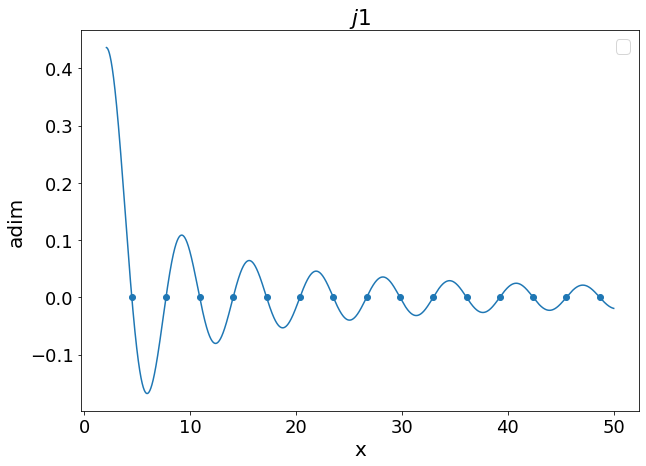

In [25]:
equis = np.linspace(2.1, 50, 1000000) 
def j1bessel(x):
    return (math.sin(x)/x/x)-(math.cos(x)/x)

fequis=np.array([j1bessel(e) for e in equis])
#rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

ceros=[]
b=0
i=1
j=0
modo=0
valor=fequis[0]
while b==0:
    if modo==0:
        valor2=fequis[i]
        if (valor2<0 and j==0):
            ceros.append(equis[i-1])
            j=1

        if valor2>valor:
            modo=1
            j=0
        
        valor=valor2
    if modo==1:
        valor2=fequis[i]
        if (valor2>0 and j==0):
            ceros.append(equis[i-1])
            j=1
        if valor2<valor:
            modo=0
            j=0
        valor=valor2
    i=i+1
    if i>len(fequis)-1:
        b=1
ceros=np.array(ceros) 
scatter=np.array([j1bessel(e) for e in ceros])     
print(ceros)
print(scatter)
plt.figure(figsize=(10, 7))
ax = plt.subplot()
#ax.plot(ene,rateNa, label = "Na")
ax.plot(equis,fequis)
ax.scatter(ceros,scatter)
#ax.plot(ene,rate_NaI, label = "NaI")
ax.set_title(r'$j1$')
ax.set_ylabel(r'adim',fontsize=20)
ax.set_xlabel(r'x',fontsize=20)
ax.legend()


In [26]:
def Ebessel(z,A):
    a=z*z
    R=1.2*A**0.3333
    b=(R*R-5)*1e-30/1.9733e-16/1.9733e-16
    c=2*A*mn
    

    retval=a/b/c
    return retval*1000000

cerosff=np.array([Ebessel(a,8) for a in ceros])
print(cerosff)


[  69481.85427343  205376.16108007  409170.29727459  680889.78922704
 1020541.14712964 1428114.44328147 1903616.19384446 2447048.95724778
 3058411.42778714 3737700.35186829 4484925.47248029 5300078.45807102
 6183145.29876856 7134161.1653044  8153097.57561164]


In [27]:
print((5/1.2/1.2)**(3/2))

6.470104101561893


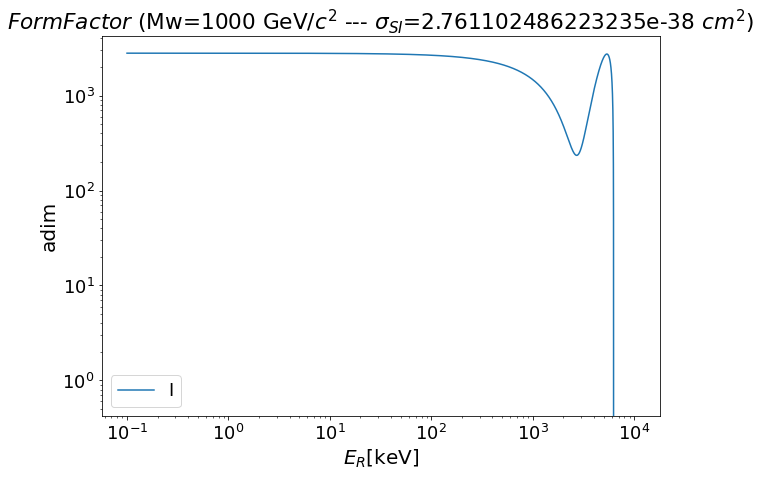

In [28]:
def f2(x):
    a=math.exp(2*x)
    b= 2800 - 10000*x + 14000*x**2 - 9800*x**3 + 3800*x**4 - 840*x**5 + 100.*x**6 - 6.3*x**7 + 0.15*x**8
    return a*b
def FF2(E,A):
  if E==0:
    return 1
  b=41.467/(45*A**(-0.333)-25*A**(-0.666))
  b=math.sqrt(b)
  mN=A*mn
  q=math.sqrt(2*1e-6*mN*E) # GeV
  x=q*b/2
  x=x*x
  return f2(x)

energies = np.linspace(0.1, 10000, 100000) # keV
#energies = np.linspace(0.1, 1e3, 10000) # keV
ene=energies


FACTORFORMA=np.array([FF2(e,127) for e in ene])
#rate_NaI=np.array([RateNaI(e,timeAvg,mW,si) for e in ene])

#Dibujamos

plt.figure(figsize=(10, 7))
ax = plt.subplot()
#ax.plot(ene,rateNa, label = "Na")
ax.plot(ene,FACTORFORMA, label = "I")

#ax.plot(ene,rate_NaI, label = "NaI")
ax.set_title(r'$Form Factor$ (Mw=' + str(np.round(mW)) + ' GeV/$c^2$ --- $\sigma_{SI}$=' + str(si) + ' $cm^2$)')
ax.set_ylabel(r'adim',fontsize=20)
ax.set_xlabel(r'$E_{R}$'+ '[keV]',fontsize=20)
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")



Text(0.5, 1.0, 'Operator 1, m = 100 GeV')

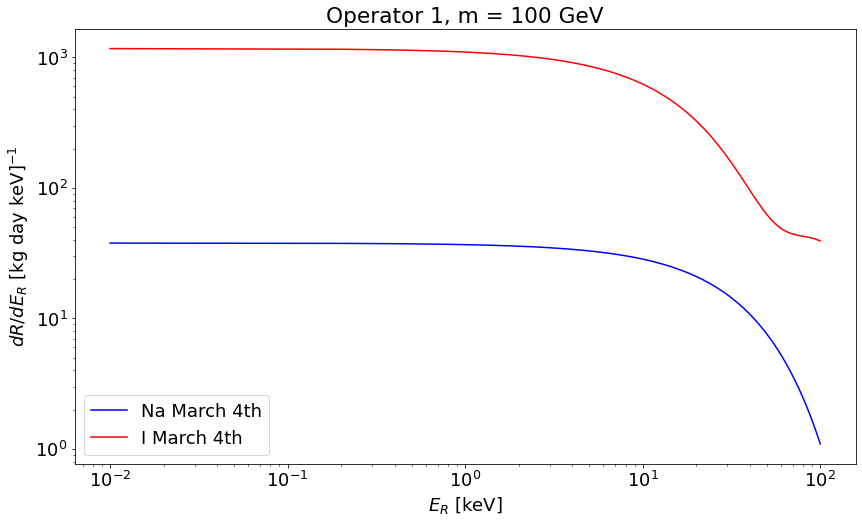

In [29]:

energies = np.linspace(0.01, 100, 500) # keV
m = 100 # GeV


reset_coefficients()
set_any_Ncoeff(1, 1, "p")
set_any_Ncoeff(1, 1, "n")

drde_Na_1 = diffrate_mod(m, energies, target='Na')
drde_I_1 = diffrate_mod(m, energies, target='I')

plt.figure(figsize=(14, 8))
plt.loglog(energies, drde_Na_1, 'b', label='Na March 4th')
plt.loglog(energies, drde_I_1, 'r', label='I March 4th')

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$dR/dE_R$ [kg day keV]$^{-1}$")
plt.legend()
plt.title(f"Operator 1, m = {m} GeV")

Text(0.5, 1.0, 'Operator 1, mchi = 100 GeV')

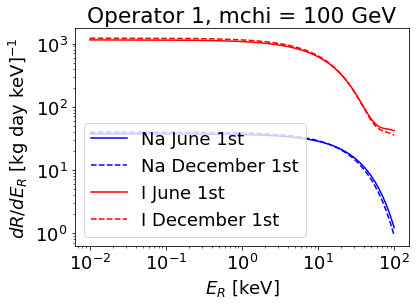

In [30]:
plt.loglog(energies, diffrate_mod(m, energies, target='Na',day=1, month=6),'b-', label='Na June 1st')
plt.loglog(energies, diffrate_mod(m, energies, target='Na',day=1, month=12),'b--', label='Na December 1st')
plt.loglog(energies, diffrate_mod(m, energies, target='I',day=1, month=6),'r-', label='I June 1st')
plt.loglog(energies, diffrate_mod(m, energies, target='I',day=1, month=12),'r--', label='I December 1st')

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$dR/dE_R$ [kg day keV]$^{-1}$")
plt.legend()
plt.title(f"Operator 1, mchi = {m} GeV")
# plt.savefig('O1_rate.pdf')
# plt.savefig('O1_rate.svg')

#### Modulation Amplitude

Now we compute the modulation amplitude.

In [31]:
mod_Na_1 = modulation(m, energies, target='Na')
mod_I_1 = modulation(m, energies, target='I')

Text(0.5, 1.0, 'Operator 1, mchi = 100 GeV')

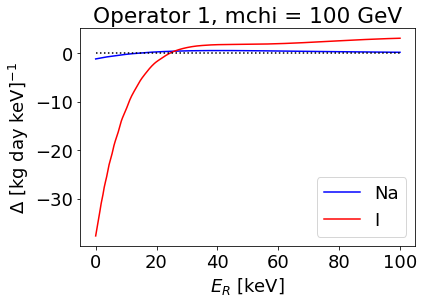

In [32]:
plt.plot(energies, mod_Na_1, 'b', label='Na')
plt.plot(energies, mod_I_1, 'r', label='I')
plt.hlines(0,0,100,'k',linestyle=':')

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$\Delta$ [kg day keV]$^{-1}$")
plt.legend()
plt.title(f"Operator 1, mchi = {m} GeV")
# plt.savefig('O1_mod.pdf')
# plt.savefig('O1_mod.svg')

#### Relative Difference

Here I compute the fractional modulation per energy.

In [33]:
av_Na_1 = rate_av(m, energies, target='Na')
av_I_1 = rate_av(m, energies, target='I')

Text(0.5, 1.0, 'Operator 1, mchi = 100 GeV')

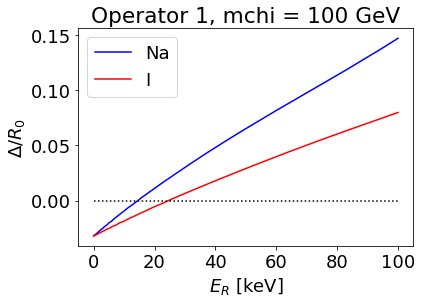

In [34]:
plt.plot(energies, mod_Na_1 / av_Na_1, 'b', label='Na')
plt.plot(energies, mod_I_1 / av_I_1, 'r', label='I')
plt.hlines(0,0,100,'k',linestyle=':')

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$\Delta/R_0$")
plt.legend()
plt.title(f"Operator 1, mchi = {m} GeV")

### Operator $\mathcal{O}_8$

We do the same for operator $\mathcal{O}_8$.

In [35]:
reset_coefficients()

In [36]:
set_any_Ncoeff(1, 8, "p")
set_any_Ncoeff(1, 8, "n")

In [37]:
drde_Na_8 = diffrate_mod(m, energies, target='Na')
drde_I_8 = diffrate_mod(m, energies, target='I')

Text(0.5, 1.0, 'Operator 8, mchi = 100 GeV')

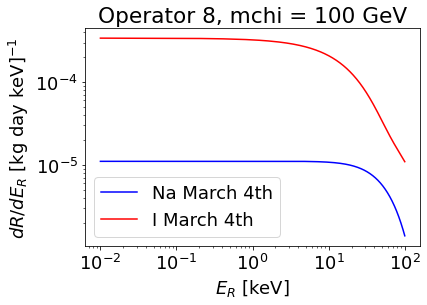

In [38]:
plt.loglog(energies, drde_Na_8, 'b', label='Na March 4th')
plt.loglog(energies, drde_I_8, 'r', label='I March 4th')

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$dR/dE_R$ [kg day keV]$^{-1}$")
plt.legend()
plt.title(f"Operator 8, mchi = {m} GeV")

Text(0.5, 1.0, 'Operator 8, mchi = 100 GeV')

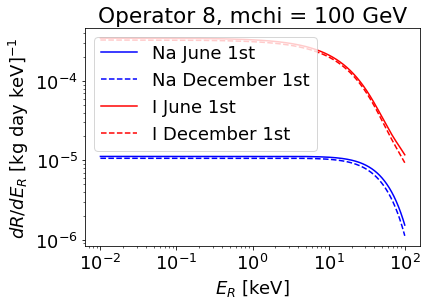

In [39]:
plt.loglog(energies, diffrate_mod(m, energies, target='Na',day=1, month=6),'b-', label='Na June 1st')
plt.loglog(energies, diffrate_mod(m, energies, target='Na',day=1, month=12),'b--', label='Na December 1st')
plt.loglog(energies, diffrate_mod(m, energies, target='I',day=1, month=6),'r-', label='I June 1st')
plt.loglog(energies, diffrate_mod(m, energies, target='I',day=1, month=12),'r--', label='I December 1st')

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$dR/dE_R$ [kg day keV]$^{-1}$")
plt.legend()
plt.title(f"Operator 8, mchi = {m} GeV")
# plt.savefig('O8_rate.pdf')
# plt.savefig('O8_rate.svg')# 

In [40]:
mod_Na_8 = modulation(m, energies, target='Na')
mod_I_8 = modulation(m, energies, target='I')

Text(0.5, 1.0, 'Operator 8, mchi = 100 GeV')

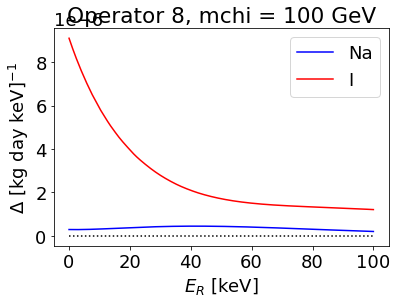

In [41]:
plt.plot(energies, mod_Na_8, 'b', label='Na')
plt.plot(energies, mod_I_8, 'r', label='I')
plt.hlines(0,0,100,'k',linestyle=':')

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$\Delta$ [kg day keV]$^{-1}$")
plt.legend()
plt.title(f"Operator 8, mchi = {m} GeV")
# plt.savefig('O8_mod.pdf')
# plt.savefig('O8_mod.svg')

In [42]:
av_Na_8 = rate_av(m, energies, target='Na')
av_I_8 = rate_av(m, energies, target='I')

Text(0.5, 1.0, 'Operator 8, mchi = 100 GeV')

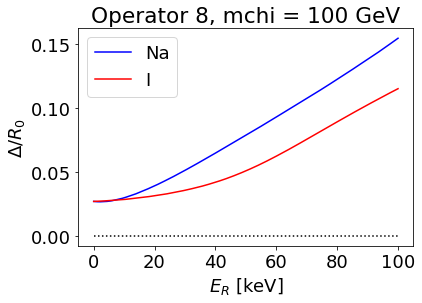

In [43]:
plt.plot(energies, mod_Na_8 / av_Na_8, 'b', label='Na')
plt.plot(energies, mod_I_8 / av_I_8, 'r', label='I')
plt.hlines(0,0,100,'k',linestyle=':')

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$\Delta/R_0$")
plt.legend()
plt.title(f"Operator 8, mchi = {m} GeV")

## Comparison of modulation amplitude

Let's re-scale contributions for each operators just to see more clearly the different behaviour of modulation amplitude.

Text(0.5, 1.0, 'Sodium, mchi = 100 GeV')

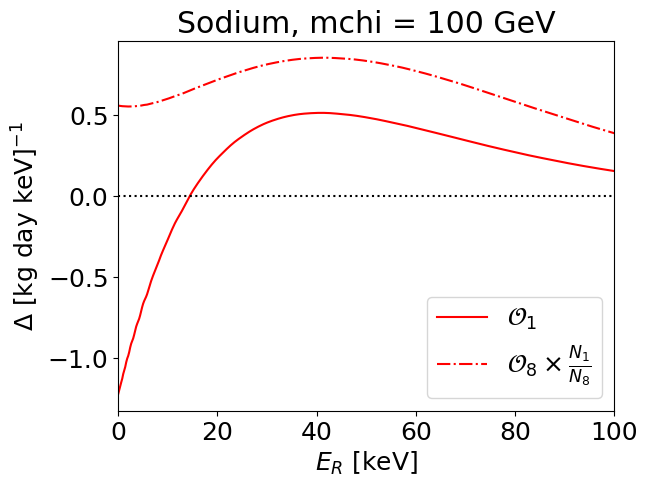

In [ ]:
plt.plot(energies, mod_Na_1, 'r', label=r'$\mathcal{O}_1$')
plt.plot(energies, mod_Na_8*normNa, '-.r', label=r'$\mathcal{O}_8\times\frac{N_1}{N_8}$')
plt.hlines(0,0,100,'k',linestyle=':')

plt.xlim(0,100)

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$\Delta$ [kg day keV]$^{-1}$")
plt.legend()
plt.title(f"Sodium, mchi = {m} GeV")
# plt.savefig('Na_mod.pdf')
# plt.savefig('Na_mod.svg')

Text(0.5, 1.0, 'Iodine, mchi = 100 GeV')

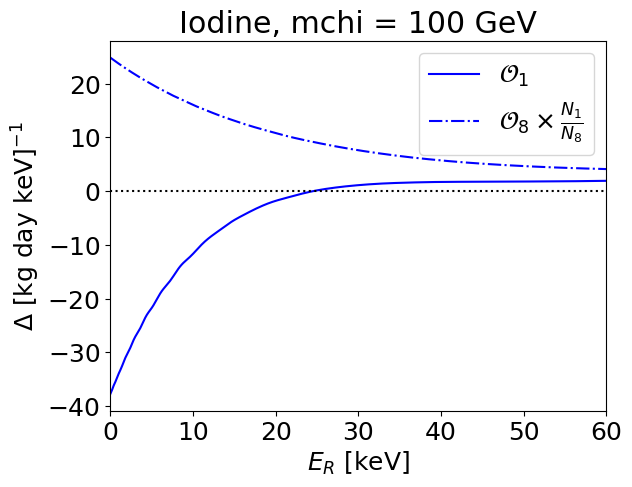

In [ ]:
plt.plot(energies, mod_I_1, 'b', label=r'$\mathcal{O}_1$')
plt.plot(energies, mod_I_8*normI, '-.b', label=r'$\mathcal{O}_8\times\frac{N_1}{N_8}$')
plt.hlines(0,0,100,'k',linestyle=':')

plt.xlim(0,60)

plt.xlabel(r"$E_R$ [keV]")
plt.ylabel(r"$\Delta$ [kg day keV]$^{-1}$")
plt.legend()
plt.title(f"Iodine, mchi = {m} GeV")
# plt.savefig('I_mod.pdf')
# plt.savefig('I_mod.svg')